In this notebook I will be going through the various steps in the pipeline to try to understand why it seems that adding
external information by joining new tables does not help with downstream tasks. 



In [1]:
cd ..

/home/soda/rcappuzz/work/benchmark-join-suggestions


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import wandb

from pathlib import Path

import src.pipeline as pipeline
from src._join_aggregator import JoinAggregator
from src.data_structures.loggers import ScenarioLogger
from src.data_structures.metadata import MetadataIndex, RawDataset, CandidateJoin
from src.utils.indexing import write_candidates_on_file
from src.utils.joining import execute_join, aggregate_table
from src.methods.evaluation import evaluate_single_table

In [4]:
pl.Config.set_fmt_str_lengths(100)
pl.Config.set_tbl_rows(20)


polars.config.Config

In [5]:
# Select the yadl version
yadl_version = "wordnet_cp_big_fx"
# yadl_version = "open_data"

# Prepare the metadata
metadata_dir = Path(f"data/metadata/{yadl_version}")
metadata_index_path = Path(f"data/metadata/_mdi/md_index_{yadl_version}.pickle")
mdata_index = MetadataIndex(index_path=metadata_index_path)

# Prepare the index dir
index_dir = Path(f"data/metadata/_indices/{yadl_version}")

# Prepare the query table
query_tab_path = Path("data/source_tables/company-employees-depleted.parquet")

base_table = pl.read_parquet(query_tab_path)
tab_name = query_tab_path.stem
base_table = base_table.drop("name")
print(base_table.columns)

['target', 'col_to_embed']


In [12]:
run_label, best_estimator, best_result = evaluate_single_table(
    base_table, "target", run_label="base_table", iterations=100, verbose=0
)
print(f"{best_result:.4f}")


-0.0000


In [33]:
import src.utils.joining as utils
from catboost import CatBoostError, CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_validate, GroupKFold
import polars.selectors as cs


src_df = base_table
target_column = "target"
group_column = "col_to_embed"
iterations = 100
n_splits = 5
verbose = 0
n_jobs = 1  

wandb.init(
    project="debug",
    config={
        "src_df": str(query_tab_path),
        "target_column": target_column,
    }
)

y = src_df[target_column].to_pandas()
df = src_df.drop(target_column)
df = utils.cast_features(df)
cat_features = df.select(cs.string()).columns
groups = df.select(
    pl.col(group_column).cast(pl.Categorical).cast(pl.Int16).alias("group")
).to_numpy()

df = df.fill_null(value="null").fill_nan(value=np.nan).to_pandas()
model = CatBoostRegressor(
    cat_features=cat_features, iterations=iterations, l2_leaf_reg=0.01
)

gkf = GroupKFold(n_splits)

results = cross_validate(
    model,
    X=df,
    y=y,
    scoring=("r2"),
    cv=gkf,
    # cv=n_splits,
    groups=groups,
    n_jobs=n_jobs,
    fit_params={"verbose": verbose},
    return_estimator=True,
)


best_r2 = np.argmax(results["test_score"])

best_estimator = results["estimator"][best_r2]


In [34]:
res_table = pl.from_dict({k: v for k, v in results.items() if k!="estimator"}).to_pandas()
wb_table = wandb.Table(dataframe=res_table)

In [38]:
wb_table

In [35]:
wandb.log(
{  "base_table":  {"res_table": wb_table, 
     "best_r2": best_r2}}
)

In [36]:
wandb.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


### Preparing random split in two

In [7]:
base_table_columns = base_table.columns
base_table_columns.remove("col_to_embed")


In [8]:
base_table_columns


['name',
 'domain',
 'year founded',
 'industry',
 'size range',
 'locality',
 'country',
 'linkedin url',
 'target']

In [9]:
first_split = list(
    np.random.choice(
        base_table_columns, size=len(base_table_columns) // 2, replace=False
    )
)
second_split = [_ for _ in base_table_columns if _ not in first_split]

In [10]:
print(first_split, second_split)


['size range', 'domain', 'locality', 'linkedin url'] ['name', 'year founded', 'industry', 'country', 'target']


In [11]:
first_split.append("col_to_embed")
second_split.append("col_to_embed")
left_table = base_table.select(pl.col(first_split))
right_table = base_table.select(pl.col(second_split))

In [12]:
on = left_on = right_on = "col_to_embed"
aggr_right = aggregate_table(right_table, right_on, aggregation_method="mean")

merged_table = execute_join(left_table, aggr_right, on="col_to_embed")

In [13]:
run_label, best_estimator, best_result = evaluate_single_table(
    merged_table, "target", run_label="split_merge", iterations=100, verbose=0
)
print(f"{best_result:.4f}")

0.7569


### Split table over all columns

In [14]:
col_combinations = []
for col in base_table.drop(["target", "col_to_embed"]).columns:
    col_combinations.append([col, "col_to_embed"])
col_combinations.append(["target", "col_to_embed"])


In [15]:
for col_c in col_combinations:
    if "target" not in col_c:
        test_table = base_table.select(pl.col(col_c), pl.col("target"))
        run_label, best_estimator, best_result = evaluate_single_table(
            test_table, "target", run_label="split_merge", iterations=100, verbose=0
        )
        print(f"{col_c} : {best_result:.2f}")

['name', 'col_to_embed'] : 0.00
['domain', 'col_to_embed'] : 0.00
['year founded', 'col_to_embed'] : 0.01
['industry', 'col_to_embed'] : 0.04
['size range', 'col_to_embed'] : 0.71
['locality', 'col_to_embed'] : 0.02
['country', 'col_to_embed'] : 0.02
['linkedin url', 'col_to_embed'] : 0.00


### Execute full join

In [16]:
merged = base_table.select(["col_to_embed", "target"])
for col_c in col_combinations:
    if "target" not in col_c:
        right_table = base_table.select(col_c)
        on = left_on = right_on = ["col_to_embed"]
        aggr_right = aggregate_table(right_table, right_on, aggregation_method="mean")
        merged = execute_join(
            merged,
            aggr_right,
            left_on=left_on,
            right_on=right_on,
            how="left",
        )

In [17]:
run_label, best_estimator, best_result = evaluate_single_table(
    merged, "target", run_label="full_join", iterations=100, verbose=0
)
print(f"{best_result:.2f}")

0.74


In [18]:
importances = pl.DataFrame(
    list(zip(best_estimator.feature_names_, best_estimator.feature_importances_)),
    schema=["feature_name", "feature_importance"],
)

In [19]:
i_pd = (
    importances.sort("feature_importance")
    .select(
        pl.col("feature_name"),
        pl.col("feature_importance").cumsum(),
    )
    .to_pandas()
)

In [20]:
seed_ = base_table.select(pl.col(["col_to_embed", "target"]))

In [21]:
merged = seed_.clone()
for r in importances.sort("feature_importance", descending=False).iter_rows():
    col, imp = r
    if col == "col_to_embed":
        continue
    comb = ("col_to_embed", col)
    right_table = base_table.select(comb)
    on = left_on = right_on = ["col_to_embed"]
    aggr_right = aggregate_table(right_table, right_on, aggregation_method="mean")
    merged = execute_join(
        merged,
        aggr_right,
        left_on=left_on,
        right_on=right_on,
        how="left",
    )
    run_label, best_estimator, best_result = evaluate_single_table(
        merged, "target", run_label="full_join", iterations=100, verbose=0
    )
    print(f"{comb} | {best_result:.2f}")

('col_to_embed', 'name') | 0.00
('col_to_embed', 'domain') | 0.00
('col_to_embed', 'linkedin url') | 0.00
('col_to_embed', 'locality') | 0.02
('col_to_embed', 'year founded') | 0.03
('col_to_embed', 'industry') | 0.05
('col_to_embed', 'country') | 0.05
('col_to_embed', 'size range') | 0.74


### Adding a fake "class" column

In [22]:
base_table_aug = base_table.with_columns(
    pl.when(pl.col("target") > 1.5).then(1).otherwise(0).alias("class")
)


In [23]:
run_label, best_estimator, best_result = evaluate_single_table(
    base_table_aug, "target", run_label="split_merge", iterations=100, verbose=0
)
print(f"{best_result:.2f}")

0.74


# Manually evaluating join candidates

### Querying index

In [37]:
top_k = 50
selected_index = "minhash"
index_path = Path(index_dir, selected_index + "_index.pickle")
minhash_index = pipeline.load_index(index_path, tab_name)

query_tab_metadata = RawDataset(
    query_tab_path.resolve(), "queries", "data/metadata/queries"
)
query_tab_metadata.save_metadata_to_json()
query_column = "col_to_embed"
query = base_table[query_column].drop_nulls()
query_results = minhash_index.query_index(query)
candidates = pipeline.generate_candidates(
    "minhash",
    query_results,
    mdata_index,
    query_tab_metadata.metadata,
    query_column,
    top_k,
)

In [38]:
k, candidate_join = next(iter(candidates.items()))

In [39]:
src_md, cnd_md, left_on, right_on = candidate_join.get_join_information()
src_df = pl.read_parquet(src_md["full_path"])
cnd_df = pl.read_parquet(cnd_md["full_path"])
cols_to_agg = [col for col in cnd_df.columns if col not in right_on]

In [40]:
cols_to_agg


['type', 'hasWonPrize', 'hasLatitude']

In [41]:
def get_importances(model, left_col, right_col, key_col):
    k_d = {col: 0 for col in key_col}
    l_d = {col: 1 for col in left_col}
    r_d = {col: 2 for col in right_col}
    d = dict(**k_d, **l_d, **r_d)

    importances = pl.DataFrame(
        list(zip(model.feature_names_, model.feature_importances_)),
        schema=["feature_name", "feature_importance"],
    )
    return importances.with_columns(pl.col("feature_name").alias("source").map_dict(d))


def get_fraction_missing(table, col_subset):
    return (
        table.select((pl.col(col_subset).is_null().sum() / len(table)))
        .mean(axis=1)
        .item()
    )


def get_imp_frac(imp):
    return (
        imp.melt(id_vars="source", value_vars="feature_importance")
        .pivot(
            index="variable",
            values="value",
            columns="source",
            aggregate_function="mean",
        )
        .select(
            pl.col("0").alias("imp_key"),
            pl.col("1").alias("imp_left"),
            pl.col("2").alias("imp_right"),
        )
        .to_dicts()[0]
    )

In [48]:
results = []
run_label, best_estimator, best_result = evaluate_single_table(
    base_table, "target", run_label="base_table", iterations=100, verbose=0
)

base_result = best_result
print(base_result)
left_col = [col for col in base_table.columns]

imp = get_importances(best_estimator, left_col, [], [])
frac_imp = {"imp_key": 0, "imp_left": 1, "imp_right": 0}
r_dict = {
    "df_name": "base_table",
    "r2": best_result,
    "frac_null": 0,
}

r_dict.update(frac_imp)
results.append(r_dict)

-1.5033811711084866e-06


In [49]:
for idx, (k, candidate_join) in enumerate(candidates.items()):
    src_md, cnd_md, left_on, right_on = candidate_join.get_join_information()
    src_df = pl.read_parquet(src_md["full_path"])
    cnd_df = pl.read_parquet(cnd_md["full_path"])

    aggr_right = aggregate_table(cnd_df, right_on, aggregation_method="mean")
    merged = execute_join(
        base_table,
        aggr_right,
        left_on=left_on,
        right_on=right_on,
        how="left",
        suffix="_right",
    )
    left_col = [col for col in base_table.columns if col not in left_on]
    key_col = left_on
    right_col = [col for col in merged.columns if col not in (left_col + left_on)]

    run_label, best_estimator, best_result = evaluate_single_table(
        merged, "target", run_label="full_join", iterations=100, verbose=0
    )
    print(f"{idx+1:>3}/{len(candidates)} : {best_result:.4f}")
    imp = get_importances(best_estimator, left_col, right_col, key_col)
    try:
        frac_imp = get_imp_frac(imp)
        frac_null = get_fraction_missing(merged, right_col)
    except Exception:
        continue
    r_dict = {
        "df_name": cnd_md["df_name"],
        "r2": best_result,
        "frac_null": frac_null,
        "n_left_col": len(left_col),
        "n_right_col": len(right_col),
        "n_key_col": len(key_col),
    }
    r_dict.update(frac_imp)
    results.append(r_dict)

df_results = pl.from_dicts(
    results,
)

  1/50 : 0.0153
  2/50 : 0.0106
  3/50 : -0.0000
  4/50 : -0.0000
  5/50 : 0.0004
  6/50 : 0.0052
  7/50 : 0.0737
  8/50 : -0.0000
  9/50 : -0.0000
 10/50 : 0.0050
 11/50 : -0.0000
 12/50 : 0.0014
 13/50 : -0.0000
 14/50 : 0.0051
 15/50 : 0.0004
 16/50 : 0.0001
 17/50 : -0.0000
 18/50 : 0.0004
 19/50 : 0.0143
 20/50 : 0.0001
 21/50 : -0.0000
 22/50 : 0.0742
 23/50 : 0.0016
 24/50 : 0.0011
 25/50 : 0.0744
 26/50 : 0.0044
 27/50 : 0.0005
 28/50 : 0.0011
 29/50 : 0.0759
 30/50 : 0.0101
 31/50 : -0.0000
 32/50 : -0.0000
 33/50 : -0.0000
 34/50 : 0.0120
 35/50 : 0.0049
 36/50 : 0.0902
 37/50 : 0.0085
 38/50 : 0.0825
 39/50 : 0.0005
 40/50 : 0.0087
 41/50 : 0.0008
 42/50 : 0.0898
 43/50 : 0.0116
 44/50 : 0.0086
 45/50 : 0.0023
 46/50 : 0.0008
 47/50 : 0.0838
 48/50 : 0.0087
 49/50 : 0.0079
 50/50 : 0.0875


In [51]:
df_results = df_results.with_columns(
    ((pl.col("r2") / base_result - 1) * 100).alias("difference")
).sort("difference")
df_results

df_name,r2,frac_null,imp_key,imp_left,imp_right,difference
str,f64,i64,i64,i64,i64,f64
"""base_table""",-0.000002,0,0,1,0,0.0


In [32]:
df_results.select(
    pl.corr("r2", "imp_right").alias("corr_imp_right"),
    pl.corr("r2", "frac_null").alias("corr_frac_null"),
)


corr_imp_right,corr_frac_null
f64,f64
0.947282,-0.252482


In [33]:
df_results.with_columns(
    ((pl.col("r2") / base_result - 1) * 100).alias("difference")
).sort("difference")

df_name,r2,frac_null,imp_key,imp_left,imp_right,n_left_col,n_right_col,n_key_col,difference
str,f64,f64,f64,f64,f64,i64,i64,i64,f64
"""yagowordnet_cp_wordnet_organization""",0.739066,0.999586,4.387541,11.924473,0.015477,9,14,1,-0.339556
"""wordnet_organization_isLocatedIn_wasDestroyedOnDate""",0.739761,0.998928,7.031409,11.596687,0.065032,9,3,1,-0.245801
"""wordnet_organization_isLocatedIn_participatedIn""",0.739761,0.998928,7.031409,11.596687,0.065032,9,3,1,-0.245801
"""wordnet_organization_isLocatedIn_isAffiliatedTo""",0.739761,0.998928,7.031409,11.596687,0.065032,9,3,1,-0.245801
"""wordnet_organization_isLocatedIn_hasBudget""",0.739761,0.998928,7.031409,11.596687,0.065032,9,3,1,-0.245801
"""wordnet_organization_hasWonPrize_isLocatedIn""",0.739761,0.998928,7.031409,11.596687,0.065032,9,3,1,-0.245801
"""wordnet_organization_hasExpenses_isLocatedIn""",0.739761,0.998928,7.031409,11.596687,0.065032,9,3,1,-0.245801
"""wordnet_organization_isLocatedIn_hasDuration""",0.739761,0.998928,7.031409,11.596687,0.065032,9,3,1,-0.245801
"""wordnet_organization_isLocatedIn_hasMotto""",0.739761,0.998928,7.031409,11.596687,0.065032,9,3,1,-0.245801


In [34]:
left_col = [col for col in base_table.columns if col not in left_on]
right_col = [col for col in target.columns if col not in right_on]
key_col = left_on

aggr_right = aggregate_table(target, right_on, aggregation_method="mean")
merged = execute_join(
    base_table,
    aggr_right,
    left_on=left_on,
    right_on=right_on,
    how="left",
)

run_label, best_estimator, best_result = evaluate_single_table(
    merged, "target", run_label="full_join", iterations=100, verbose=0
)
print(best_result)
imp = get_importances(best_estimator, left_col, right_col, key_col)

NameError: name 'target' is not defined

In [ ]:
imp.groupby("source").agg(pl.sum("feature_importance"))

source,feature_importance
i64,f64
0,5.615749
1,91.334566
2,3.049685


In [ ]:
imp


feature_name,feature_importance,source
str,f64,i64
"""col_to_embed""",36.553675,1
"""county_name""",0.0,0
"""party""",61.699804,1
"""local_education_agency_lea""",0.043022,2
"""lea_type""",0.038553,2
"""school_name""",0.000195,2
"""administrative_unit_number_aun""",0.120865,2
"""county_code""",0.153815,2
"""school_number""",0.084684,2


In [ ]:
df_results.select(pl.corr("r2", "frac_null"))


r2
f64
0.783251


### Plot importances

In [ ]:
cmap = {0: "red", 1: "blue", 2: "green"}

i_df = imp.with_columns(pl.col("feature_name").alias("source").map_dict(d)).to_pandas()
i_df["color"] = i_df["source"].map(cmap)

NameError: name 'd' is not defined

<BarContainer object of 15 artists>

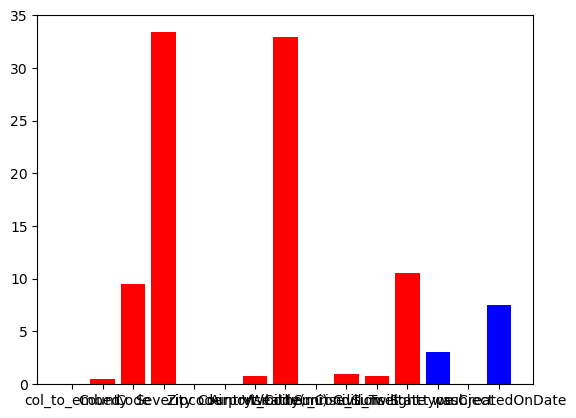

In [ ]:
plt.bar(data=i_df, x="feature_name", height="feature_importance", color=i_df["color"])
